# Introduction
Originally, the data come from [this research](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full). 

In this notebook, I explore data, perform an EDA, pre-processing and train and test models for multi-class classification. In future, I plan to do binary classifications healthy control vs. main/specific disorders to see feature importance.

# Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import matplotlib.style
import os
import pickle
from functools import partial
from math import ceil
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy

In [2]:
sns.set_style('whitegrid')

# Read Data

In [3]:
df = pd.read_csv('./eeg_machinelearing_data_BRMH.csv') 
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


Let's rename some of the columns:
- XX.X.band.x.channel to band.channel
- COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2

In [4]:
# function to rename
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
# rename columns
df.rename(reformat_name, axis=1, inplace=True)
# show df
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


# Exploratory data analysis
Data includes:
- patients' information
    - no. - patients unique id
    - sex - M (male) or F (female)
    - age
    - eeg.date - date of EEG
    - education - years of educations
    - IQ - intelligence quotient
- diagnosis
    - main.disorder
    - specific.disorder
- QEEG PSD (power spectrum density) -  absolute power value in each frequency band
- QEEG FC (functional connectivity) - coherence for each band and channel  

Further details are available in the [paper](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full) and [data sheet](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full#supplementary-material).

Extract information with patients' information only:

In [5]:
patients_info = df.loc[:,'sex':'specific.disorder']
patients_info

,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder
0,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder
1,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder
2,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder
3,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder
4,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder
...,...,...,...,...,...,...,...
940,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control
941,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control
942,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control
943,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control


Identify separating colmun (with all elemens equal to NA) between PSD and FC columns:

In [6]:
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0] # alternative: sep_col = df.isna().sum().idxmax()
sep_col

'Unnamed: 122'

## Categorical varibles

Towards Data Science Post on Partial dependence plots with Scikit-learn:
    https://towardsdatascience.com/partial-dependence-plots-with-scikit-learn-966ace4864fc
    
The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 200130). 

from functool import partial 
When called, partial() allows the program to output a function object resembling the original function with a fixed argument(s) passed into it. To read more: https://www.geeksforgeeks.org/partial-functions-python/

In [7]:
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

### Diagnosis

Do we have class disbalance?

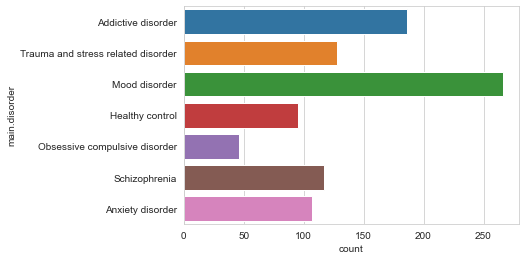

In [8]:
countplot(y='main.disorder')
plt.show()

main.disorder                       specific.disorder             
Trauma and stress related disorder  Acute stress disorder              38
                                    Adjustment disorder                38
Obsessive compulsive disorder       Obsessive compulsitve disorder     46
Anxiety disorder                    Social anxiety disorder            48
Trauma and stress related disorder  Posttraumatic stress disorder      52
Anxiety disorder                    Panic disorder                     59
Mood disorder                       Bipolar disorder                   67
Addictive disorder                  Alcohol use disorder               93
                                    Behavioral addiction disorder      93
Healthy control                     Healthy control                    95
Schizophrenia                       Schizophrenia                     117
Mood disorder                       Depressive disorder               199
dtype: int64

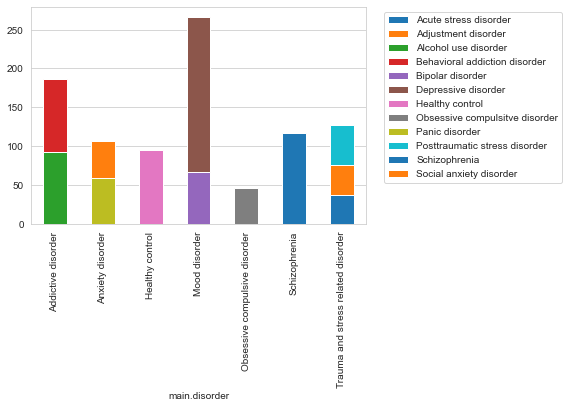

In [9]:
fig,ax = plt.subplots()
disorder_counts = df.groupby(['main.disorder', 'specific.disorder']).size()
display(disorder_counts.sort_values())
disorder_counts.unstack('specific.disorder')\
    .plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.xaxis.grid(False)
plt.show()

Indeed, we do see class disbalances. The most noticeable are:
- Obsessive compulsive disorder
- Specific disorders in Trauma and stress related disorders and Anxiety disorders categories
- Depressive disorder

### Sex
How many male and female subject are present in the dataset?

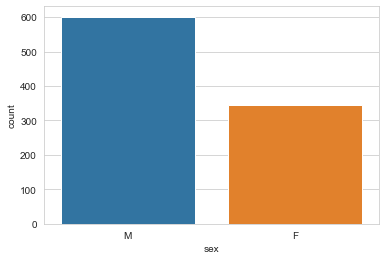

In [10]:
countplot(x='sex')
plt.show()

What is this picture for every diagnosis (main and specific)?

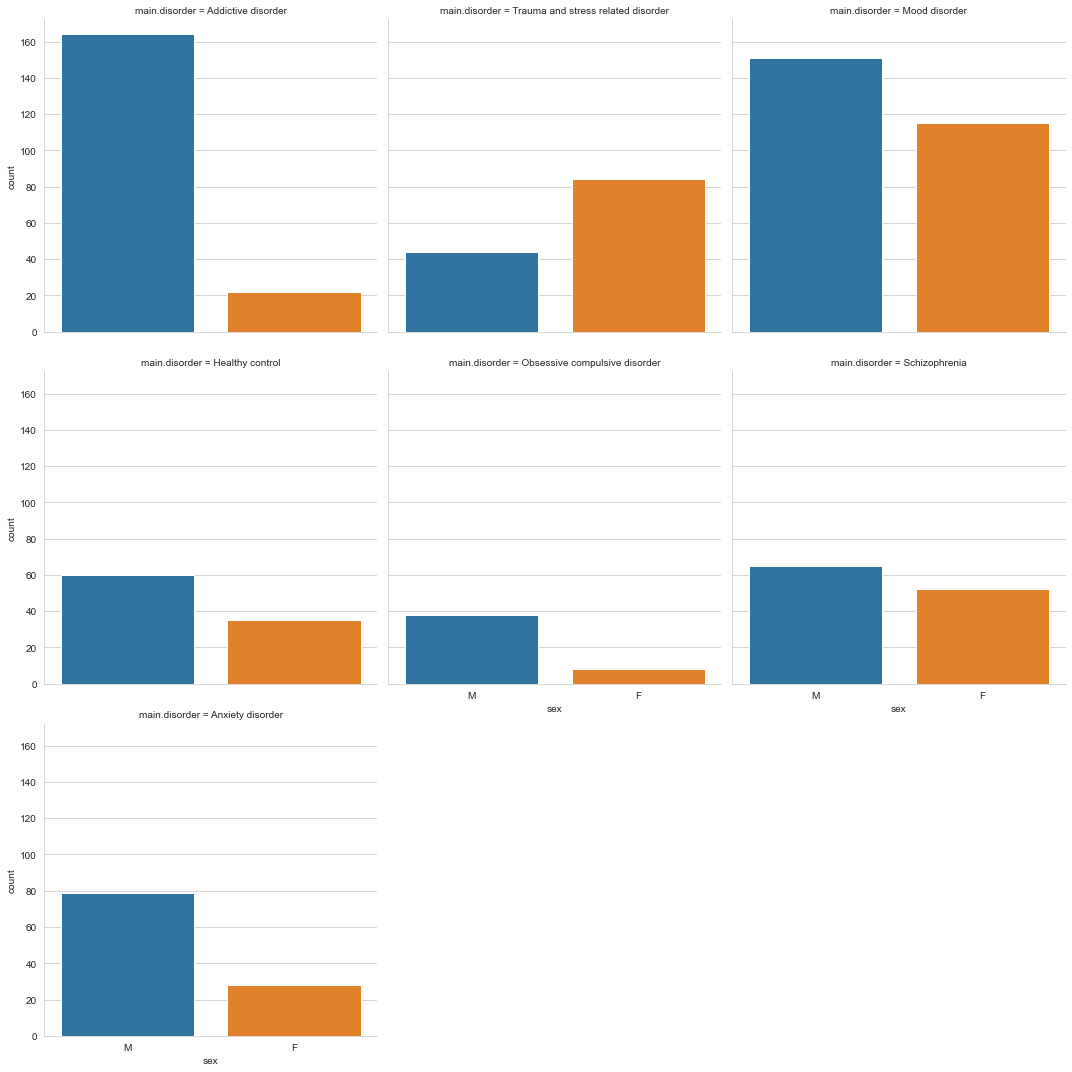

In [11]:
countplots(x='sex', col='main.disorder', col_wrap=3)
plt.show()

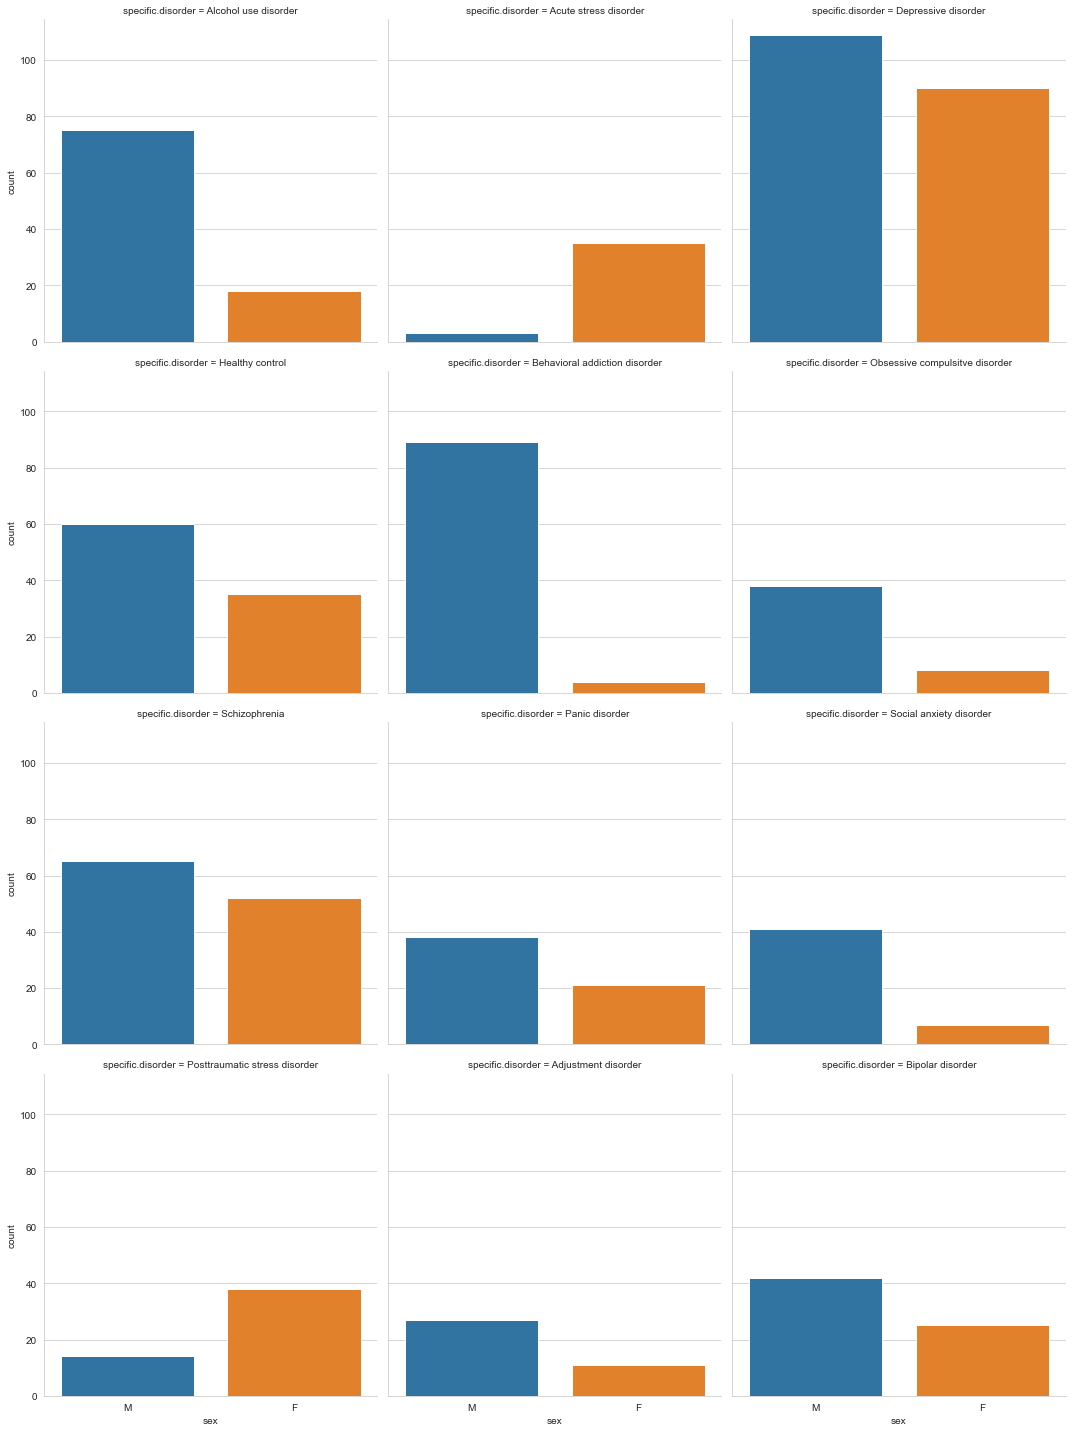

In [12]:
countplots(x='sex', col='specific.disorder', col_wrap=3)
plt.show()

## Numeric variables

In [13]:
# wide to long to make visualisations

display(patients_info)

df_long = patients_info.melt(id_vars = ['sex', 'main.disorder', 'specific.disorder'], value_vars=['age', 'education', 'IQ'])
display(df_long)

displot = partial(sns.displot, 
                  data=df_long, kind='hist', 
                  x='value', col='variable', 
                  col_wrap=3, common_bins=False,
                  facet_kws={'sharex': False, 'sharey': False})

displot2 = partial(sns.displot,
                  data=patients_info, kind='hist',  
                  col_wrap=3,facet_kws={'sharey': False})

,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder
0,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder
1,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder
2,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder
3,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder
4,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder
...,...,...,...,...,...,...,...
940,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control
941,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control
942,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control
943,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control


,sex,main.disorder,specific.disorder,variable,value
0,M,Addictive disorder,Alcohol use disorder,age,57.0
1,M,Addictive disorder,Alcohol use disorder,age,37.0
2,M,Addictive disorder,Alcohol use disorder,age,32.0
3,M,Addictive disorder,Alcohol use disorder,age,35.0
4,M,Addictive disorder,Alcohol use disorder,age,36.0
...,...,...,...,...,...
2830,M,Healthy control,Healthy control,IQ,116.0
2831,M,Healthy control,Healthy control,IQ,118.0
2832,M,Healthy control,Healthy control,IQ,113.0
2833,M,Healthy control,Healthy control,IQ,107.0


What distributions numeric variables have?

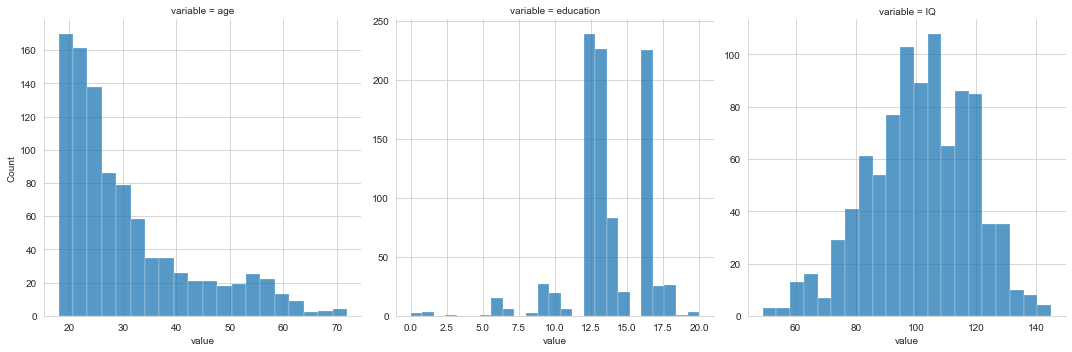

In [14]:
displot()
plt.show()

Does sex affect variable's distribution?

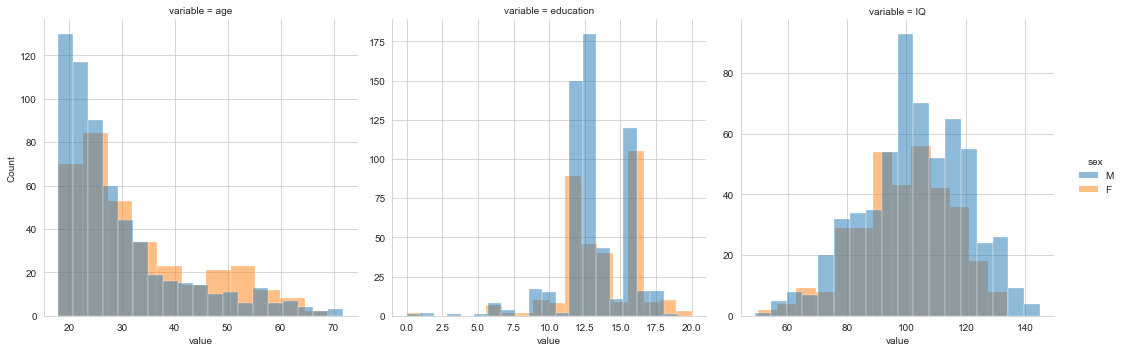

In [15]:
displot(hue='sex', alpha=0.5)
plt.show()

Sex seems to have no major affect on the distributions, they have similar shapes.

### Age

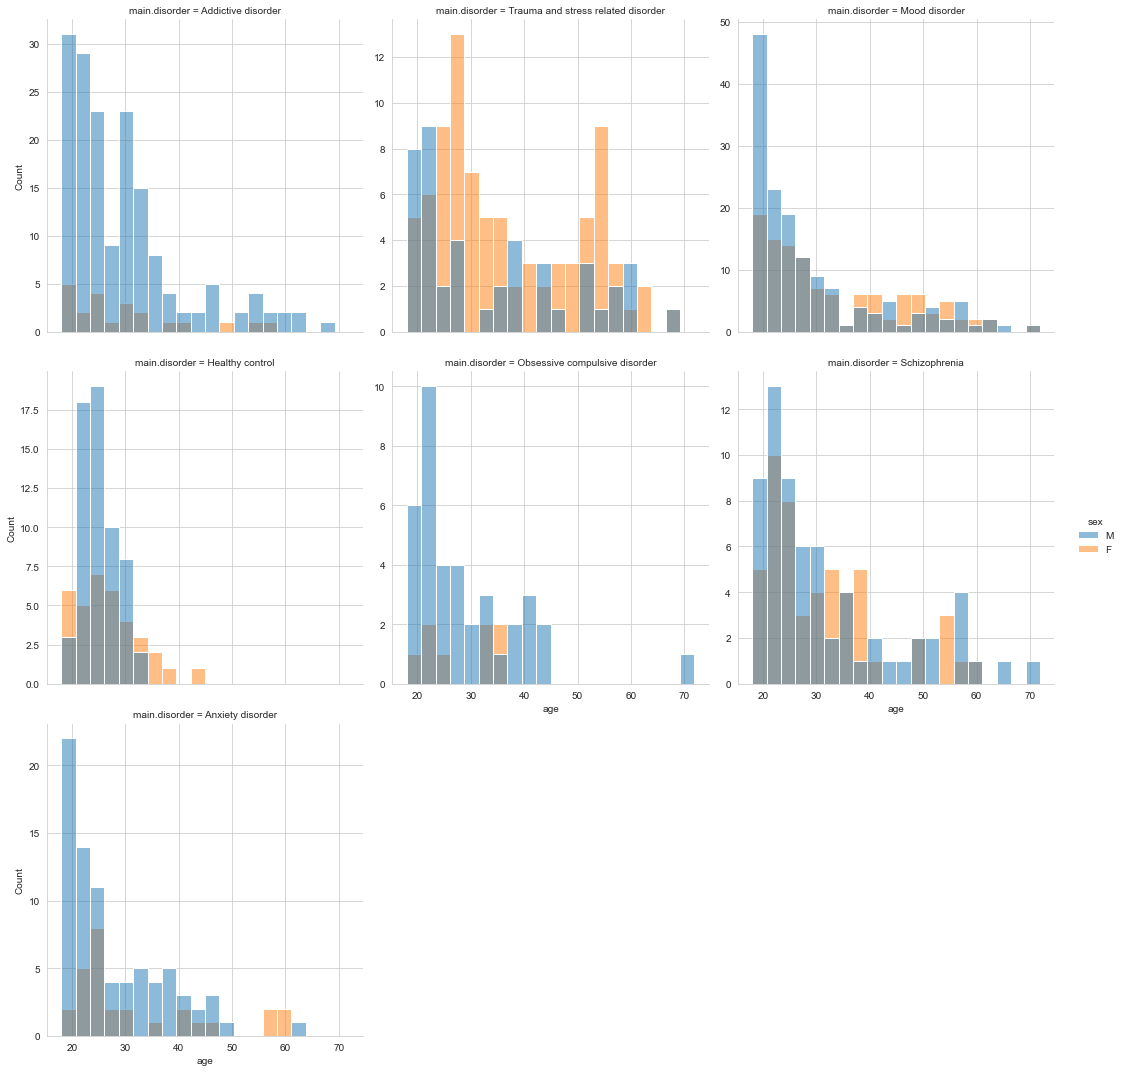

In [16]:
displot2(x='age', col='main.disorder', hue='sex')
plt.show()

Healthy controls have a narrower distribution. Trauma and stress related disorder patients have noticeably different distribution with two peaks instead of one, like in patients with other diagnosis.

What distributions are for specific diagnoses?

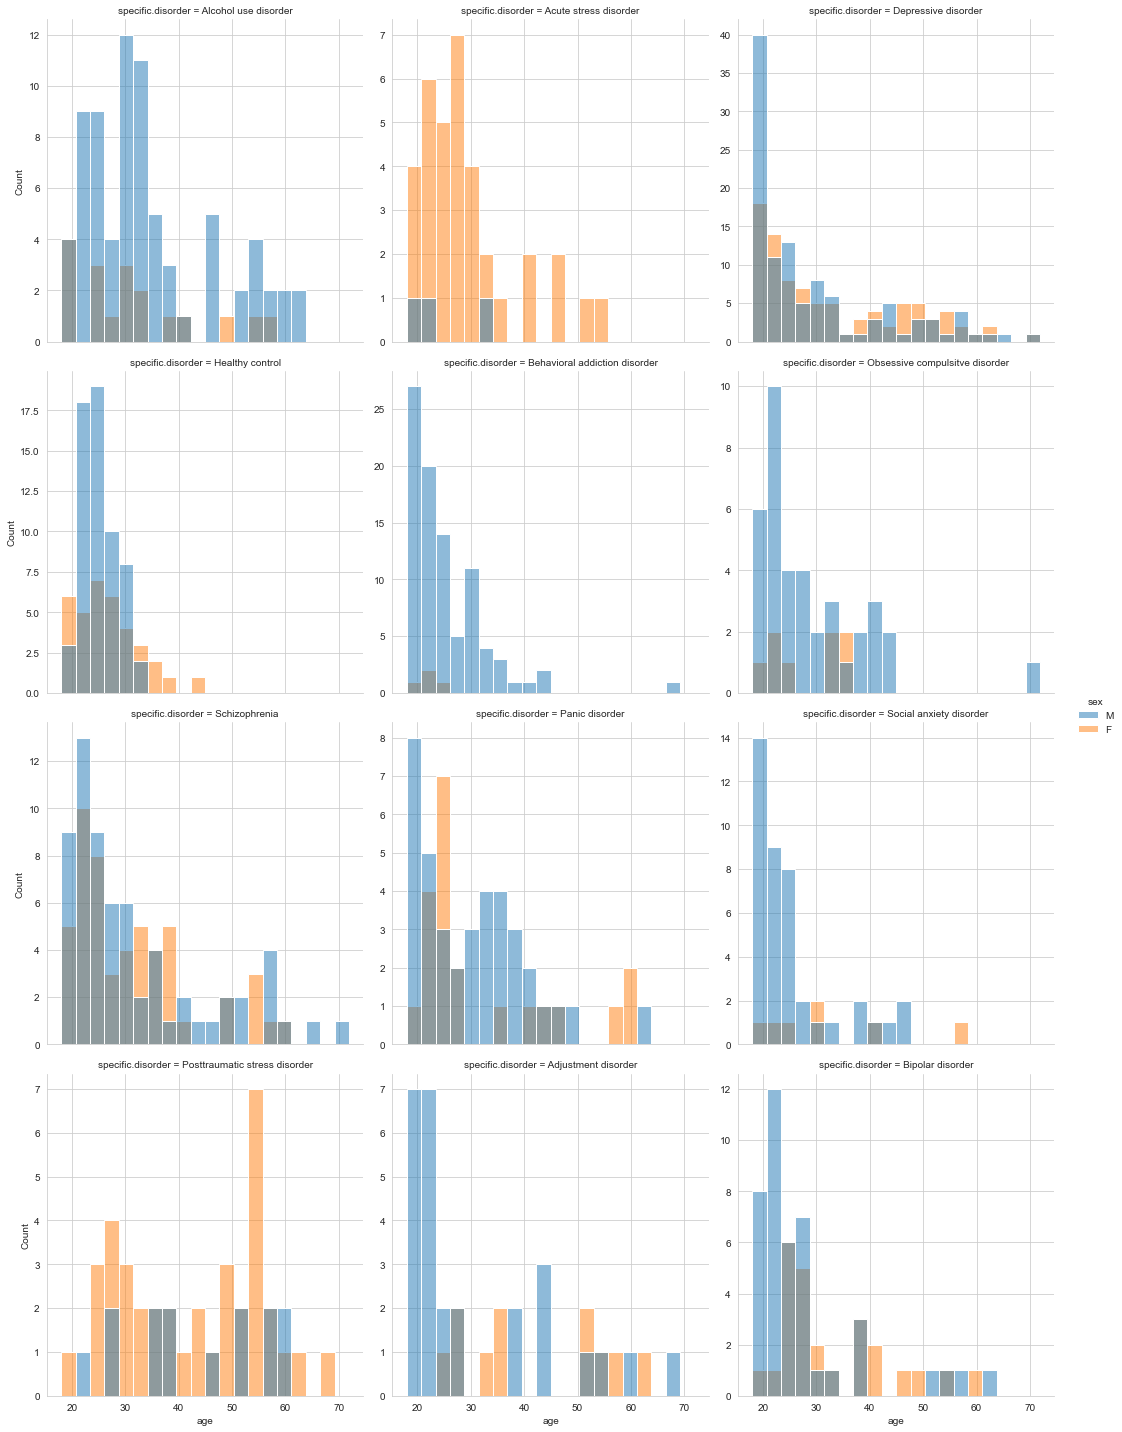

In [17]:
displot2(x='age', col='specific.disorder', hue='sex')
plt.show()

### Education

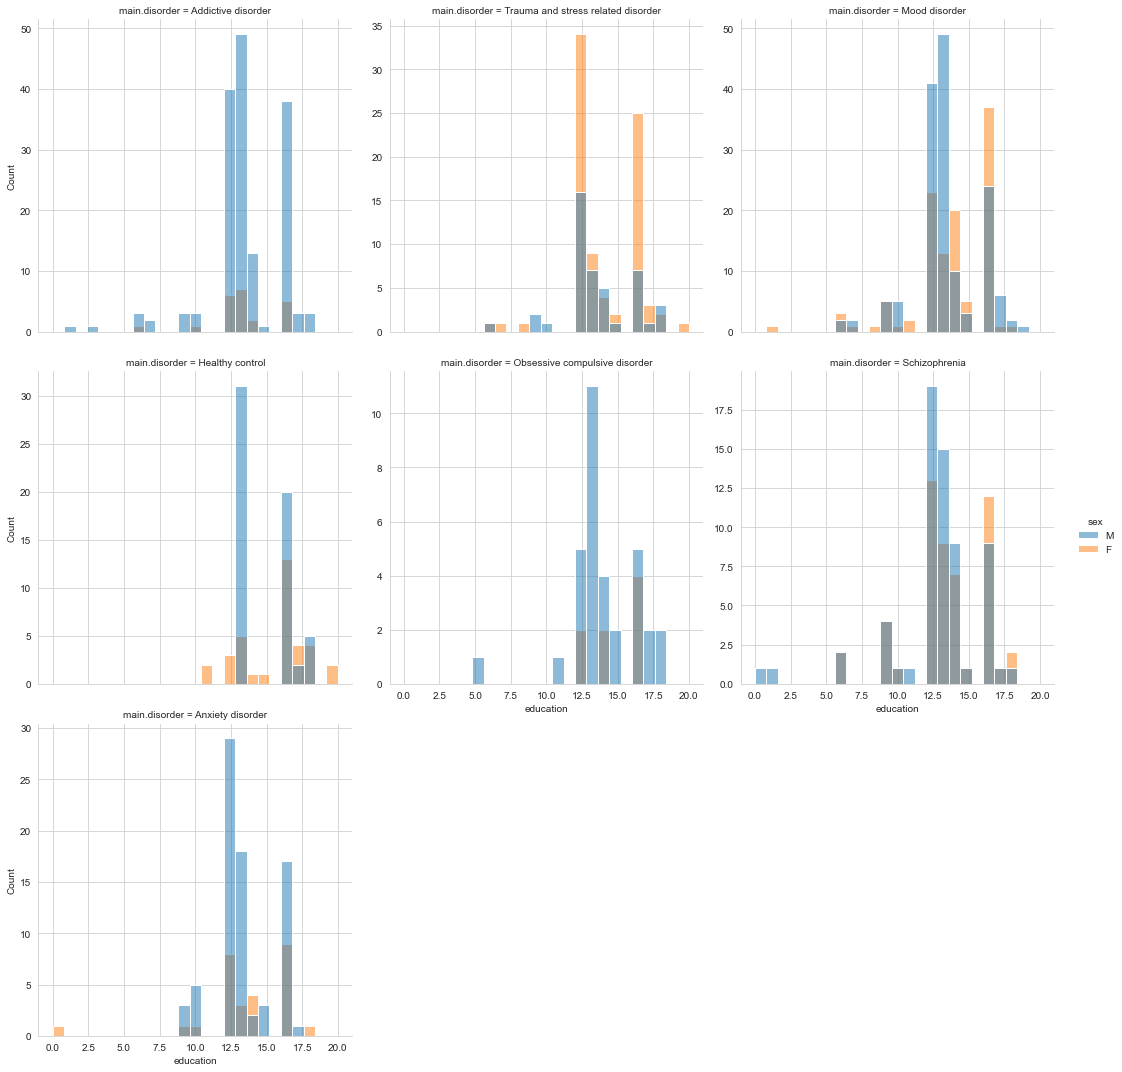

In [18]:
displot2(x='education', col='main.disorder', hue='sex')
plt.show()

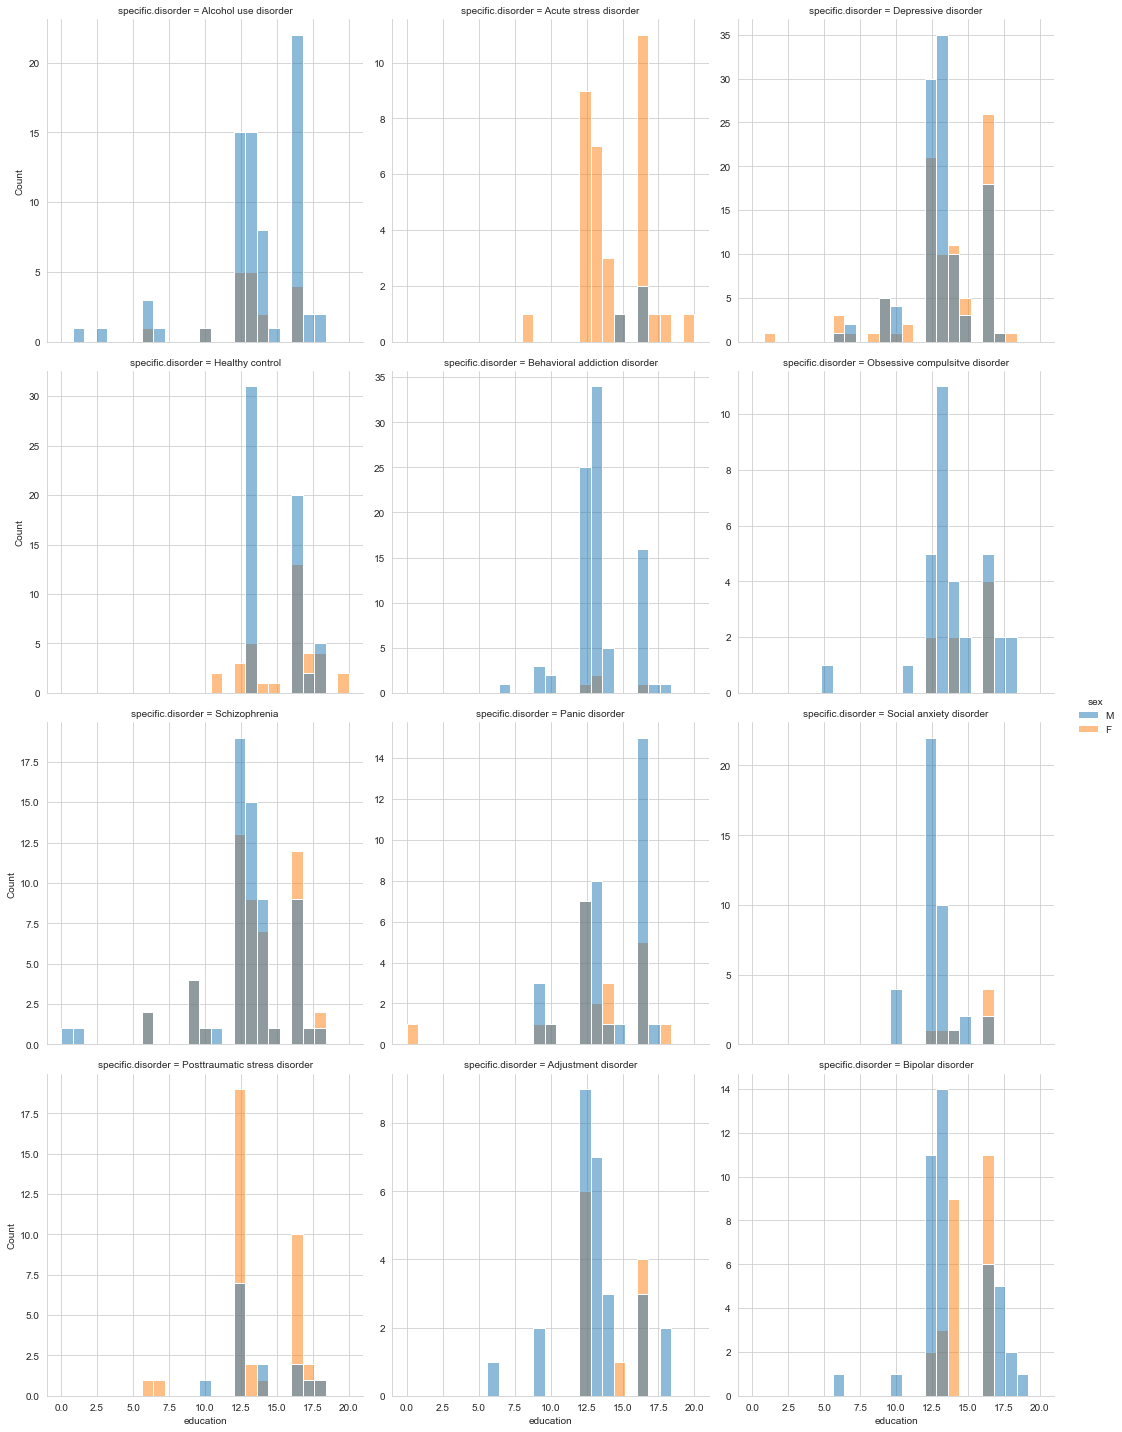

In [19]:
displot2(x='education', col='specific.disorder', hue='sex')
plt.show()

### IQ

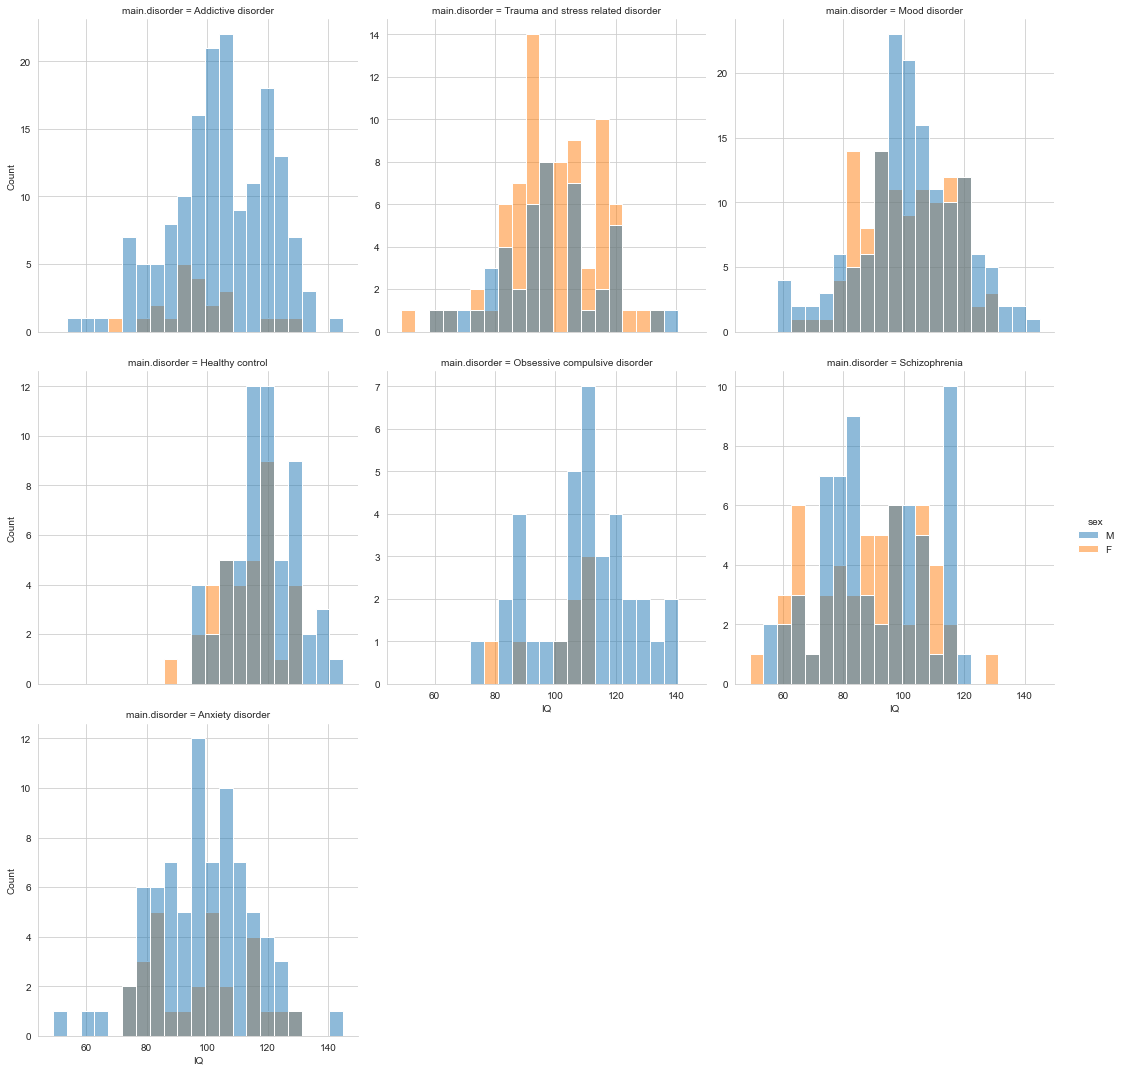

In [20]:
displot2(x='IQ', col='main.disorder', hue='sex')
plt.show()

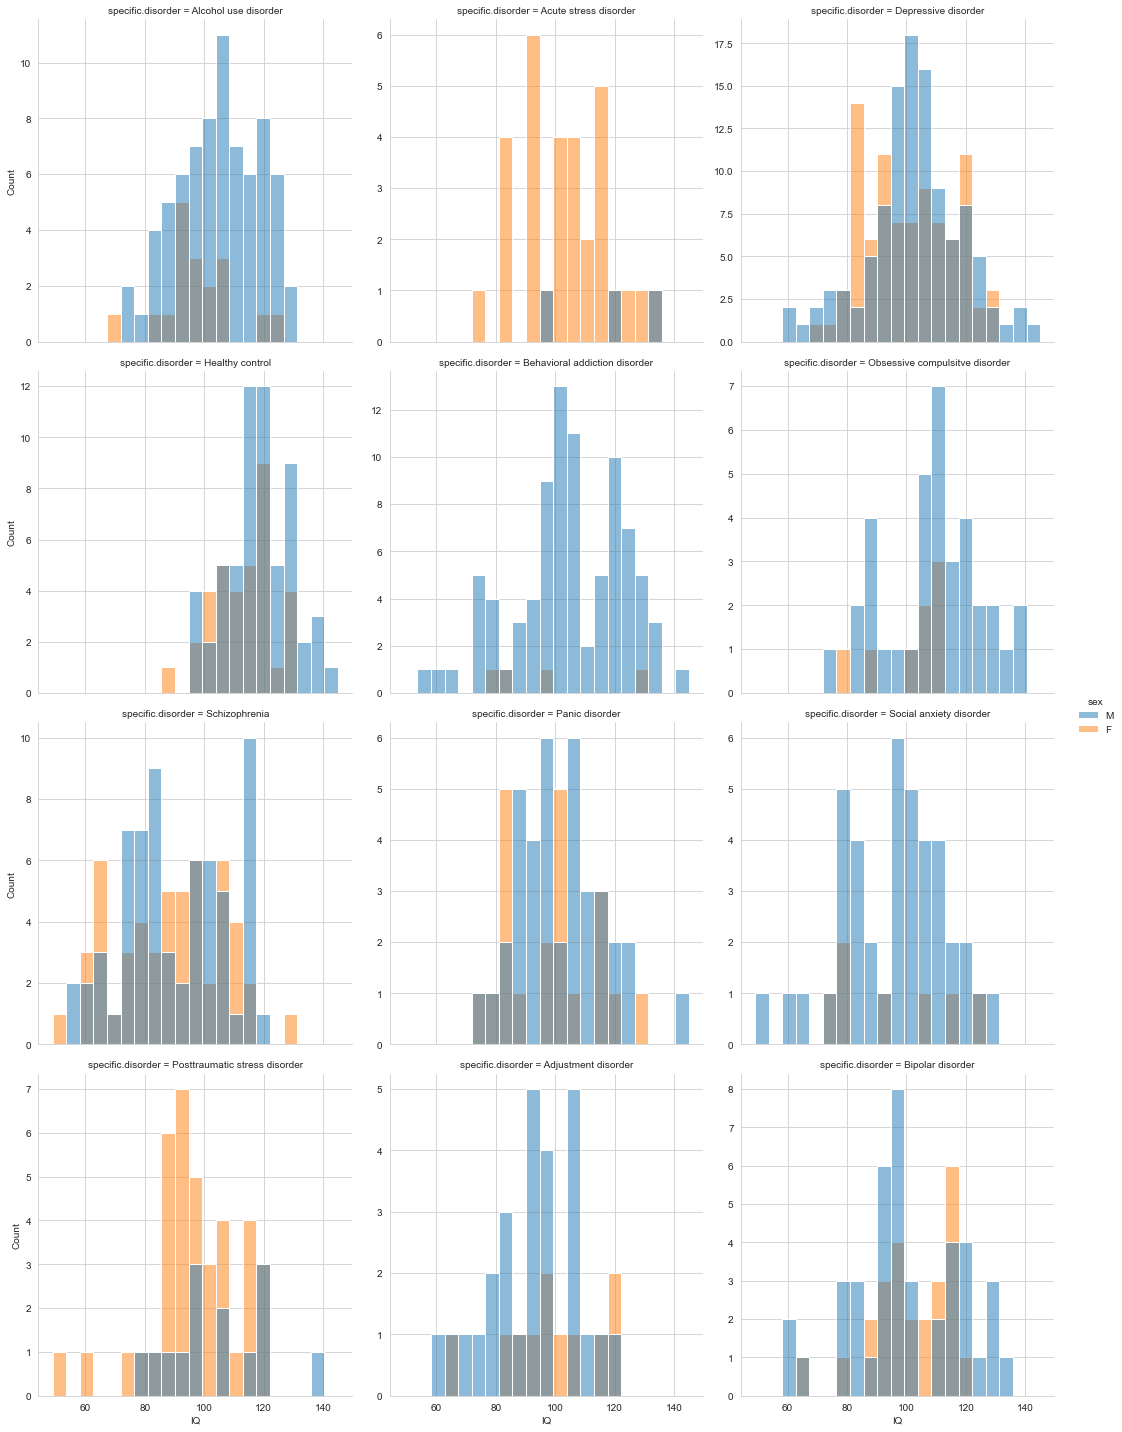

In [21]:
displot2(x='IQ', col='specific.disorder', hue='sex')
plt.show()

Next we want to look into distribution of PSD and FC columns.

### PSD (power spectral density)

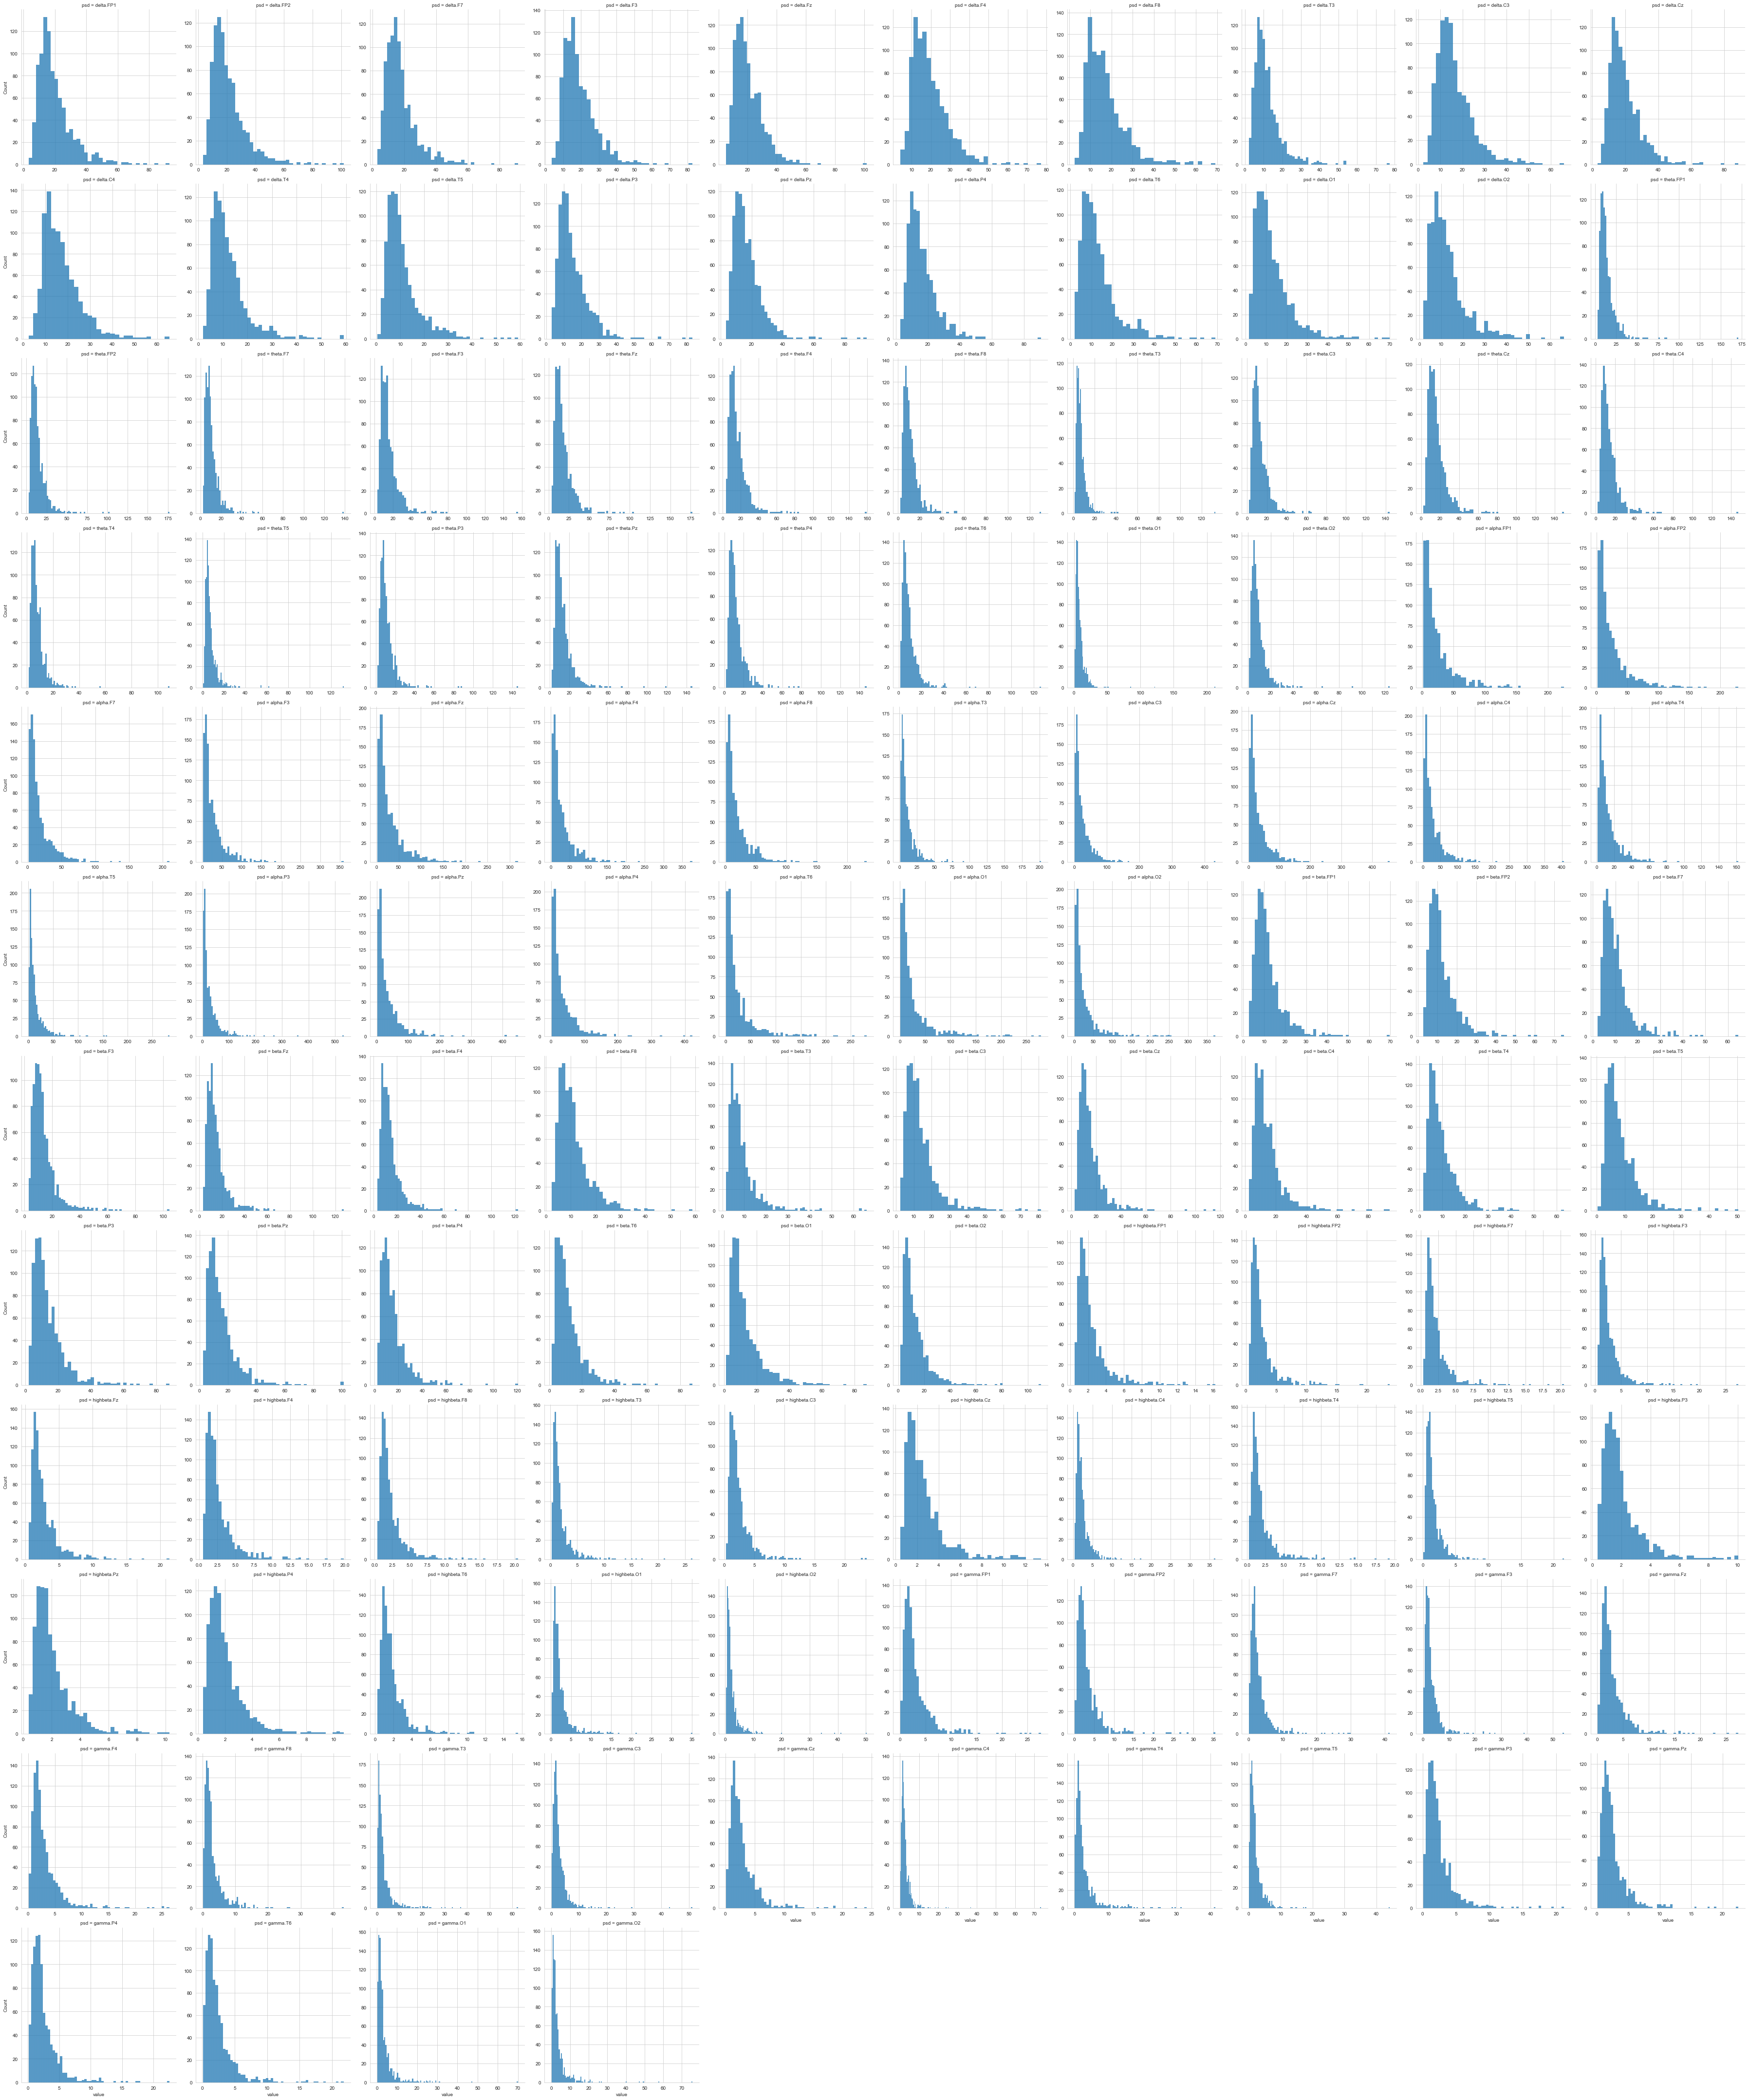

In [22]:
psd_cols = df.loc[:, 'delta.FP1':sep_col].drop(sep_col, axis=1).columns
# Create DataFrame for visualisation
psd_long = df.melt(id_vars='no.', value_vars=psd_cols, var_name='psd')
sns.displot(data=psd_long, kind='hist', x='value', col='psd', col_wrap=10, common_bins=False, facet_kws={'sharey':False, 'sharex': False})
plt.show()


### FC (functional connectivity)

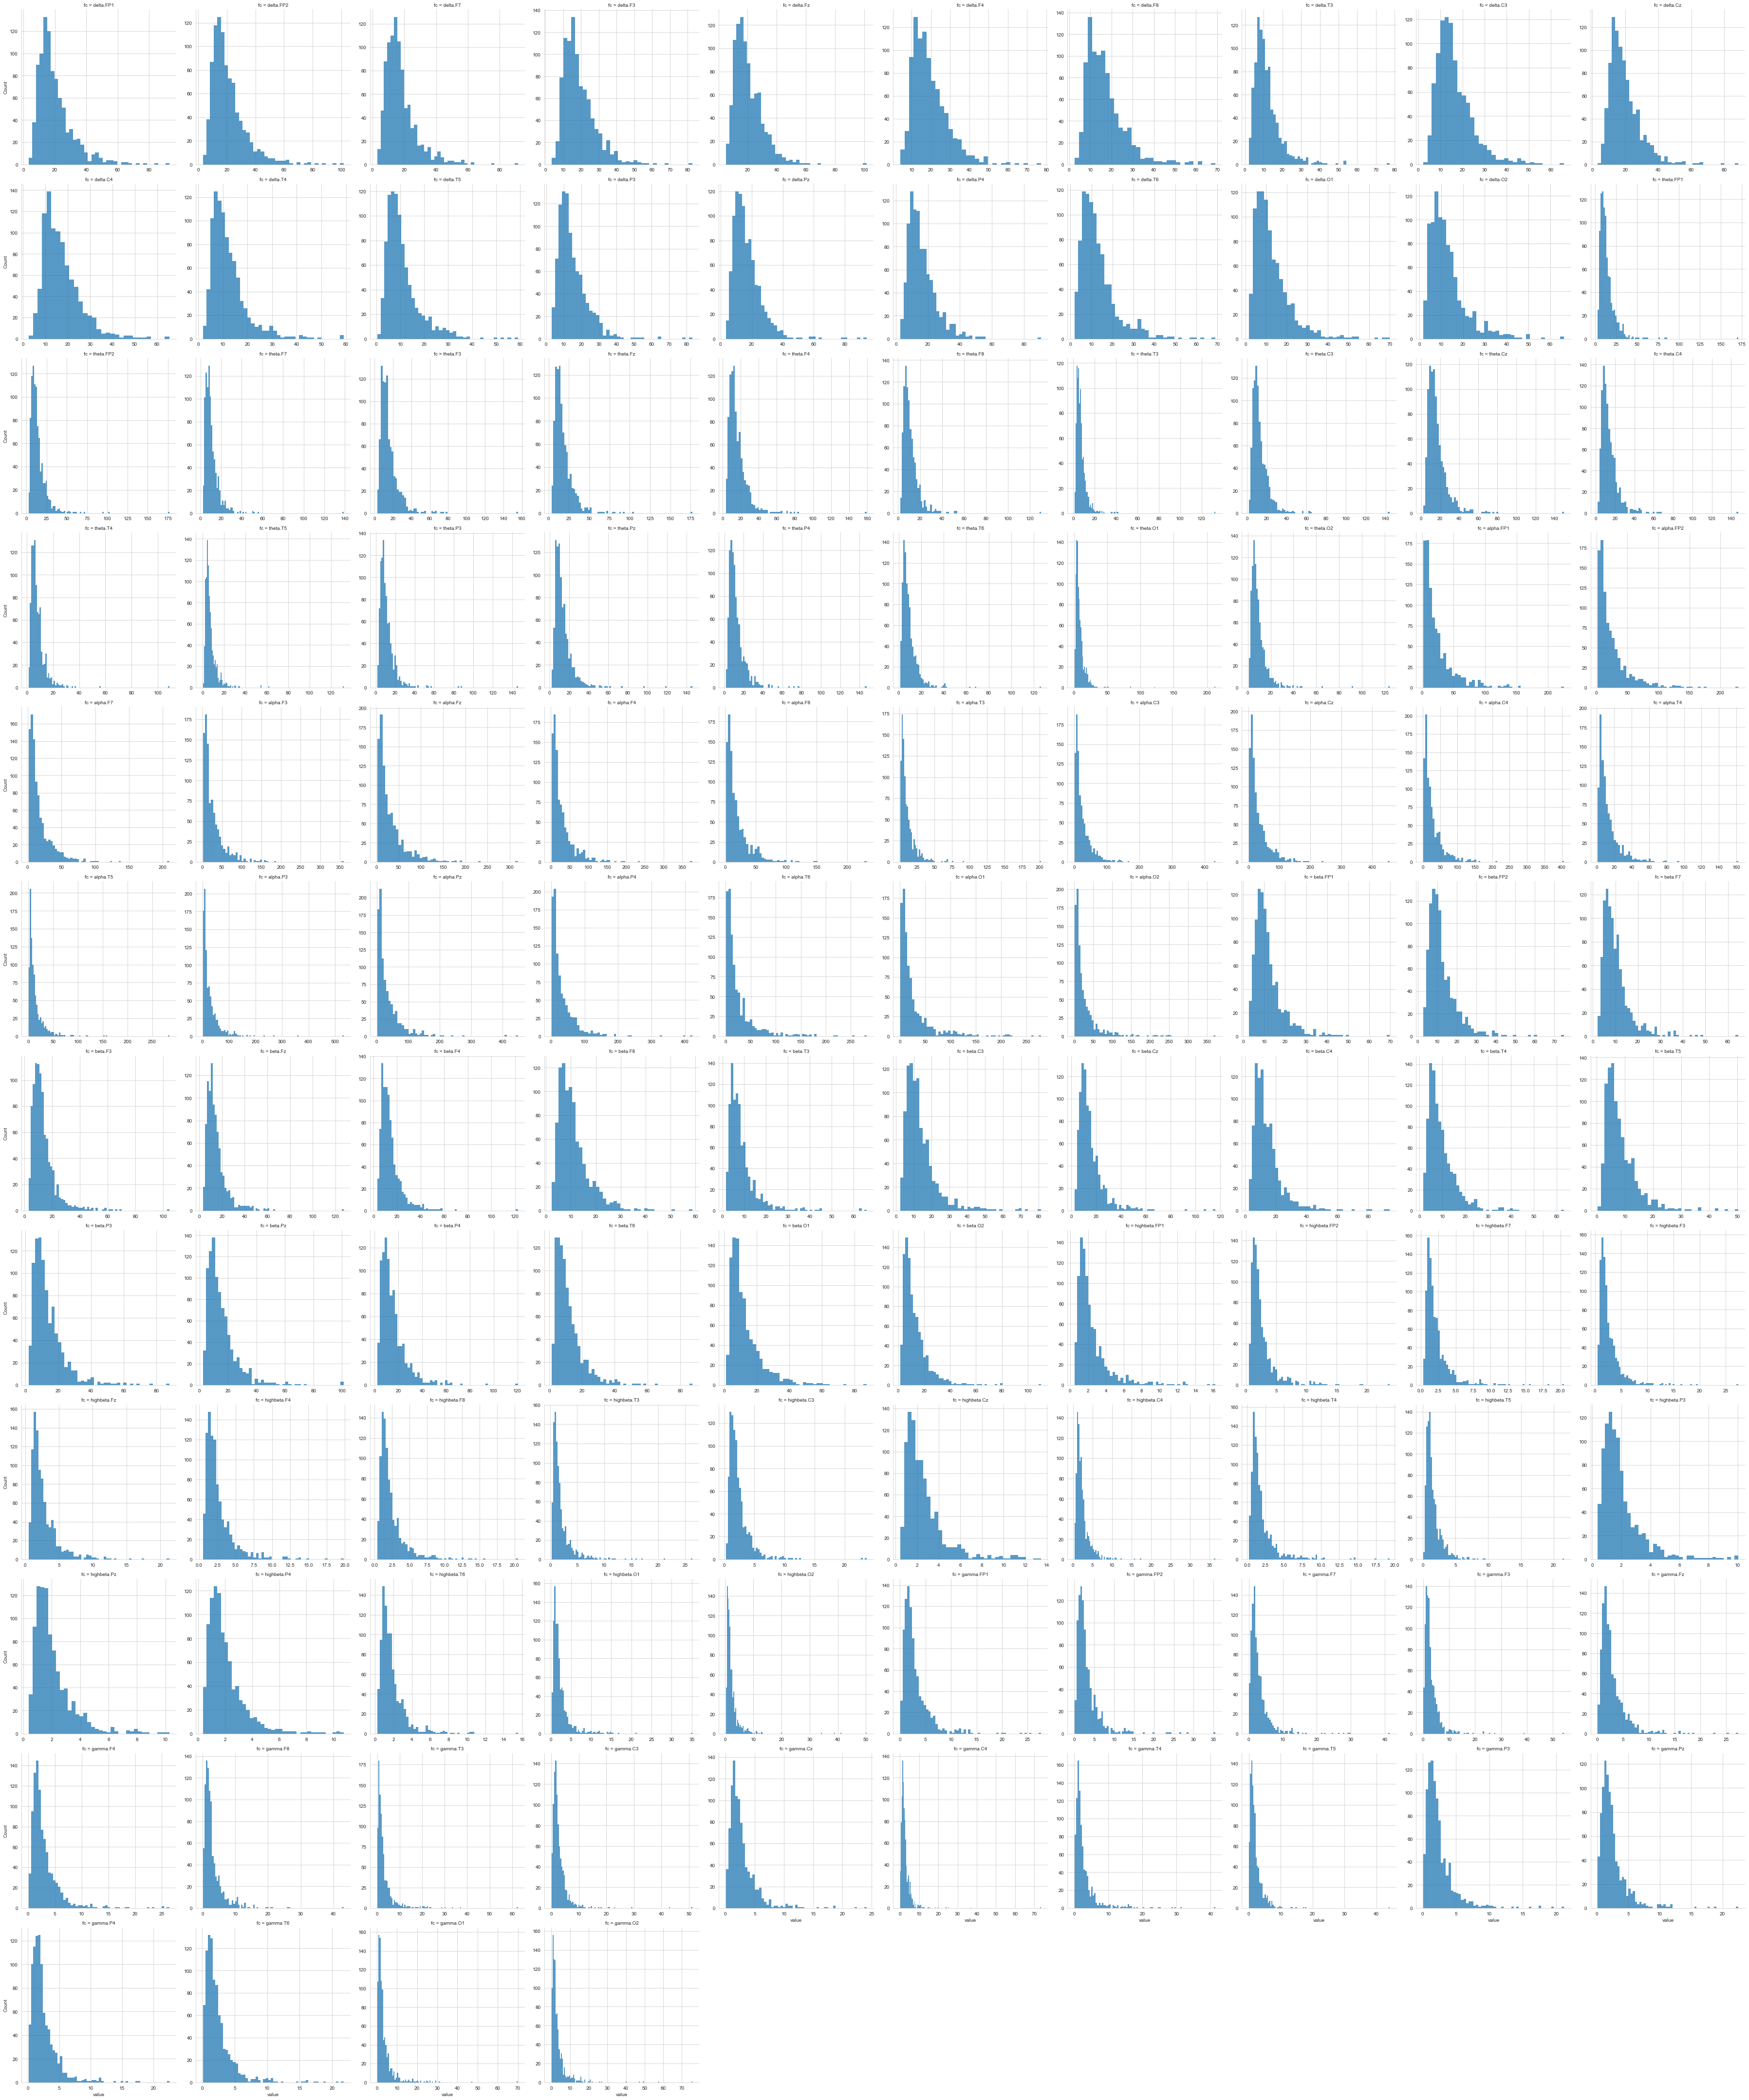

In [23]:
fc_cols = df.loc[:, sep_col:'COH.gamma.O1.O2'].drop(sep_col, axis=1).columns
fc_long = df.melt(id_vars='no.', value_vars=psd_cols, var_name='fc')
sns.displot(data=fc_long, kind='hist', x='value', col='fc', col_wrap=10, common_bins=False, facet_kws={'sharey':False, 'sharex': False})
plt.show()

### Conclusions

- IQ is normally distributed, no transformation required
- Education distribution remotely resembles normal distribution, we consider that we will not apply any transformations
- Age, PSD and FC features seem to have log-normal distribution so we need to consider applying logarithm to them.  

## Missing data

In [24]:
missing = df.isna().sum()
missing[missing > 0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [25]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.00,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
17,18,M,30.00,2013.9.27,NaN,86.0,Addictive disorder,Alcohol use disorder,12.443237,12.503703,...,85.080600,53.533875,62.817411,68.040950,71.834549,48.779049,80.516443,22.049743,76.277261,45.629506
21,22,M,20.00,2014.10.23,NaN,116.0,Addictive disorder,Alcohol use disorder,28.287190,22.412264,...,33.065475,24.351780,18.764173,32.610337,38.451805,20.933501,48.626712,16.258394,40.471735,24.175359
155,156,M,18.00,2013.12.7,NaN,103.0,Addictive disorder,Behavioral addiction disorder,16.548803,19.042179,...,93.825121,79.091595,83.132315,88.900783,87.508591,76.257681,89.811513,62.739950,84.729816,86.322844
173,174,M,23.00,2015.11.14,NaN,113.0,Healthy control,Healthy control,19.050158,23.277470,...,68.005720,54.685472,70.694110,62.676608,67.705314,46.667642,66.673782,29.689482,74.787580,51.039538
269,270,M,25.00,2015.9.23,NaN,85.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,6.186264,7.112847,...,72.743284,63.723838,61.257858,67.473157,77.664778,57.967084,73.898719,59.775191,81.941728,72.195171
270,271,M,34.00,2015.9.21,NaN,120.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.784872,15.922964,...,72.409132,49.265064,41.222401,68.010480,72.429188,26.188907,68.653874,18.072318,63.285321,41.822238
279,280,M,35.00,2016.6.2,NaN,NaN,Obsessive compulsive disorder,Obsessive compulsitve disorder,21.524573,22.227615,...,90.934877,93.568209,94.185299,92.271775,96.445879,91.470862,96.851513,92.296182,96.209585,96.660561
280,281,M,37.00,2016.6.27,NaN,110.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,11.971083,11.374465,...,91.150863,78.359575,64.861521,74.389105,89.863923,50.322649,75.469583,49.440177,84.022887,69.921675
281,282,M,22.00,2016.6.30,NaN,107.0,Obsessive compulsive disorder,Obsessive compulsitve disorder,12.516343,10.136242,...,96.419647,77.360976,95.156801,96.105427,87.746498,94.760227,97.579921,81.495805,86.770154,98.121870


What percentage of data we will loose if we drop rows with missing data (in terms of each main.disorder group)?

In [26]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


We loose too much data (13%) on patients with obsessive compulsive disorder, which is one of the smallest groups already. We should consider filling missing data.  
Our options to fill them are:
- special value
- mean/median value
- imputation

Let's fill values with median value

Note by Ortal: for some of the algorithms such as GBDTs incl. XGBoost and LGBM you should evaluate the performance also without imputation  

In [27]:
educ_iq_medians = df[['education', 'IQ']].agg(np.nanmedian)
df[['education', 'IQ']] = df[['education', 'IQ']].fillna(educ_iq_medians)
missing = df.isna().sum()
missing[missing>0]

Unnamed: 122    945
dtype: int64

In [28]:
df.to_csv('dataset.csv', index=False)

# Visualisation of PSD

In [29]:
# Define electrode positions
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

channels = pd.DataFrame(chs).transpose()
channels

,0,1
FP1,-0.030,0.080
FP2,0.030,0.080
F7,-0.073,0.047
F3,-0.040,0.041
Fz,0.000,0.038
F4,0.040,0.041
F8,0.073,0.047
T3,-0.085,0.000
C3,-0.045,0.000
Cz,0.000,0.000


In [30]:
def plot_eeg(levels, positions, fig, ch_names=None, cmap='Spectral_r', 
             marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.


    :param levels: numpy.array, shape (n_chan,)
        data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param fig: matplotlib.figure.Figure
        The figure to create colorbar on.
    :param ch_names: list | None
        List of channel names. If None, channel names are not plotted.
    :param cmap: matplotlib colormap | None
        Colormap to use. If None, ‘Reds’ is used for all positive data, otherwise defaults to ‘RdBu_r’.
        Default value is 'Spectral_r'
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return axes: matplotlib.axes.Axes
        axes of the figure
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    axes = fig.subplots(1, 2, gridspec_kw={'width_ratios': [12, 1]})
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes[0], names=ch_names, vlim=(vmin, vmax),
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)    
    #axes[1].set_position([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = fig.colorbar(im, cax=axes[1])
    return axes

def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0, char_space=2,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    """
    Visualisation of pre-processed EEG dataset.
    See example of usage on Kaggle (https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data)
    :param dataset: pandas.DataFrame
        Data set to visualise. See format of the dataset on Kaggle (url above).
    :param channels: pandas.DataFrame
        Channel (index) names and positions (columns: x and y).
    :param gwidth: float
        Width of single topology map.
    :param gheight: float
        Height of single topology map.
    :param wspace: float
        Space between subplots
    :param marker_style:
        marker_style: dict
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='black', markeredgecolor='k', linewidth=0, markersize=2)
    :param band_ordered: list | None
        List of EEG bands (e.g. delta, gamma, etc.), they must be one or more columns of dataset DataFrame.
        Provides a way to control the order (form top to bottom) of bands in the resulted complex figure.
        If None, all columns of dataset are used in orfer of columns.
    :param conditions_ordered: list | None
        List of conditions, they must be one or more level 0 indecies of dataset DataFrame.
        Provides a way to control the order (from left to right) of conditions in the resulted complex figure.
        If None, all unique 0 level indecies of dataset are used in order they are in the dataset.
    :param band_labels: list | None
        List of custom labels for EEG bands, it must be the same length as band_ordered.
        If None, column names of dataset DataFrame are used.
    :param condition_labels:
        List of custom labels for conditions, it must be the same length as conditions_ordered.
        If None, original indecies' names of dataset DataFrame are used.
    :param kwargs:
        any other parameter used in plot_eeg
    :return: fig: matplotlib.figure.Figure
    :return: subfigs: np.array of matplotlib.figure.Figure elements
    """
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # determine the absolute max 
    absmax = ceil(dataset.max().max())
    # length of label in # of characters
    len_lab = len(str(absmax))
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # plot eeg
        ax =  plot_eeg(levels, channels.to_numpy(), subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # adjust labels
        lendiff = len_lab - len(str(vmax))
        if lendiff != 0:
            ticks = ax[1].get_yticks()
            labs = [str(round(x)).ljust(len_lab+lendiff*(char_space-1), ' ') for x in ticks]
            ax[1].yaxis.set_major_locator(mticker.FixedLocator(ticks))
            ax[1].set_yticklabels(labs)
        # annotate band (if needed)
        if j == 0:
            ax[0].set_ylabel(band_labels[i])
        else:
            ax[0].set_ylabel(" ")
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

In [31]:
# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
qeeg = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)

In [32]:
# mean powers per main disorder
main_mean = qeeg.groupby('main.disorder').mean().reset_index()
# mean powers per main disorder
spec_mean = qeeg.groupby('specific.disorder').mean().reset_index()
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix='\w+')

## Main disorders

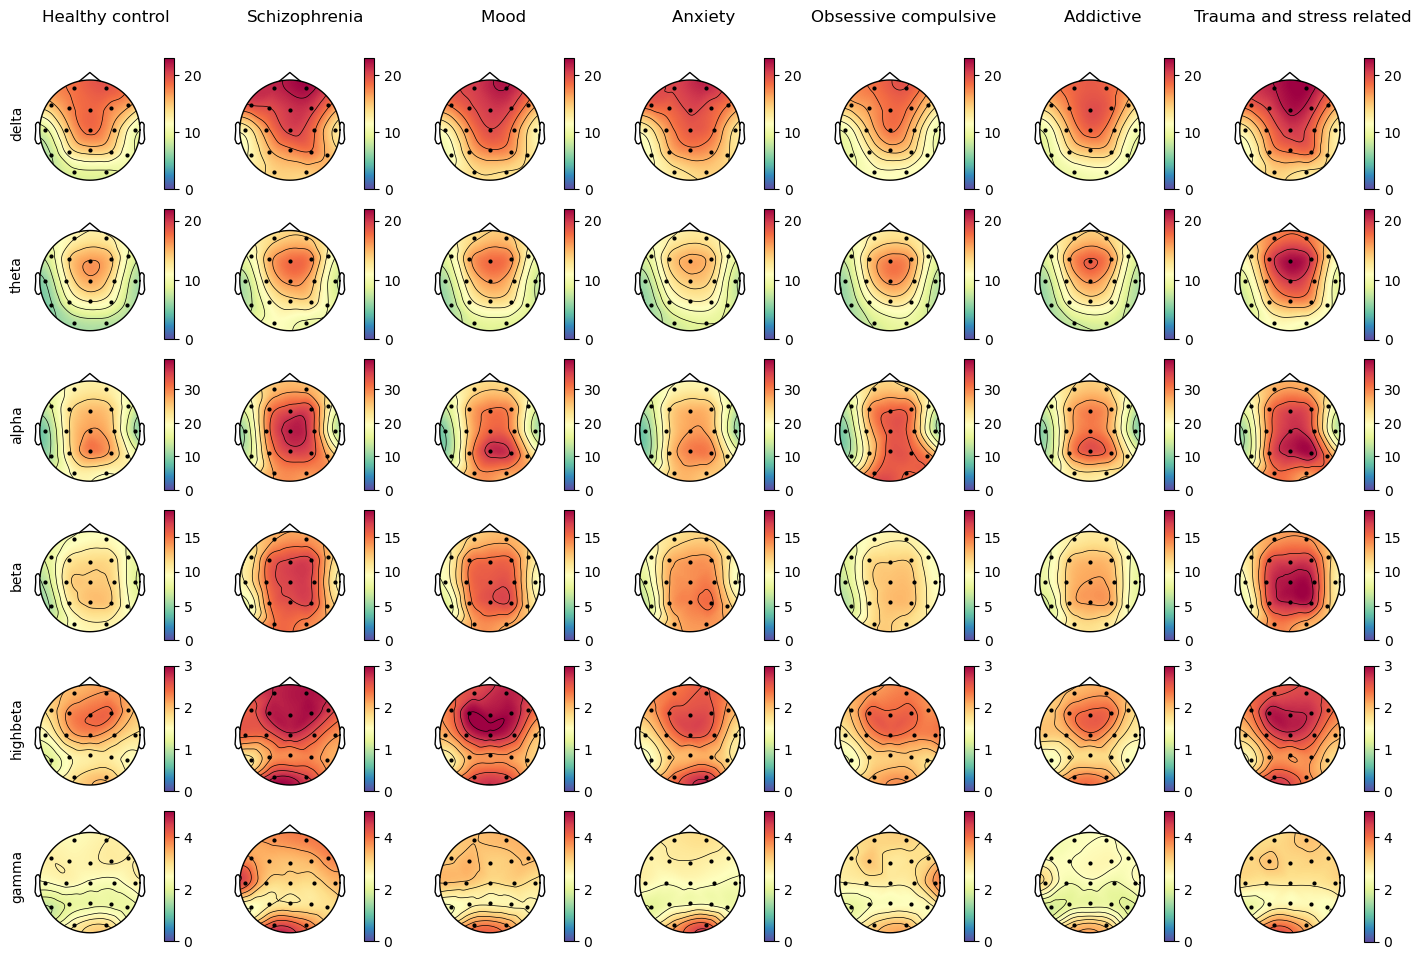

In [33]:
matplotlib.style.use('default')
# order conditions (main.disorder)
conds = ['Healthy control',
         'Schizophrenia', 
         'Mood disorder', 
         'Anxiety disorder',  
         'Obsessive compulsive disorder', 
         'Addictive disorder',
         'Trauma and stress related disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(main_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

## Specific disorders

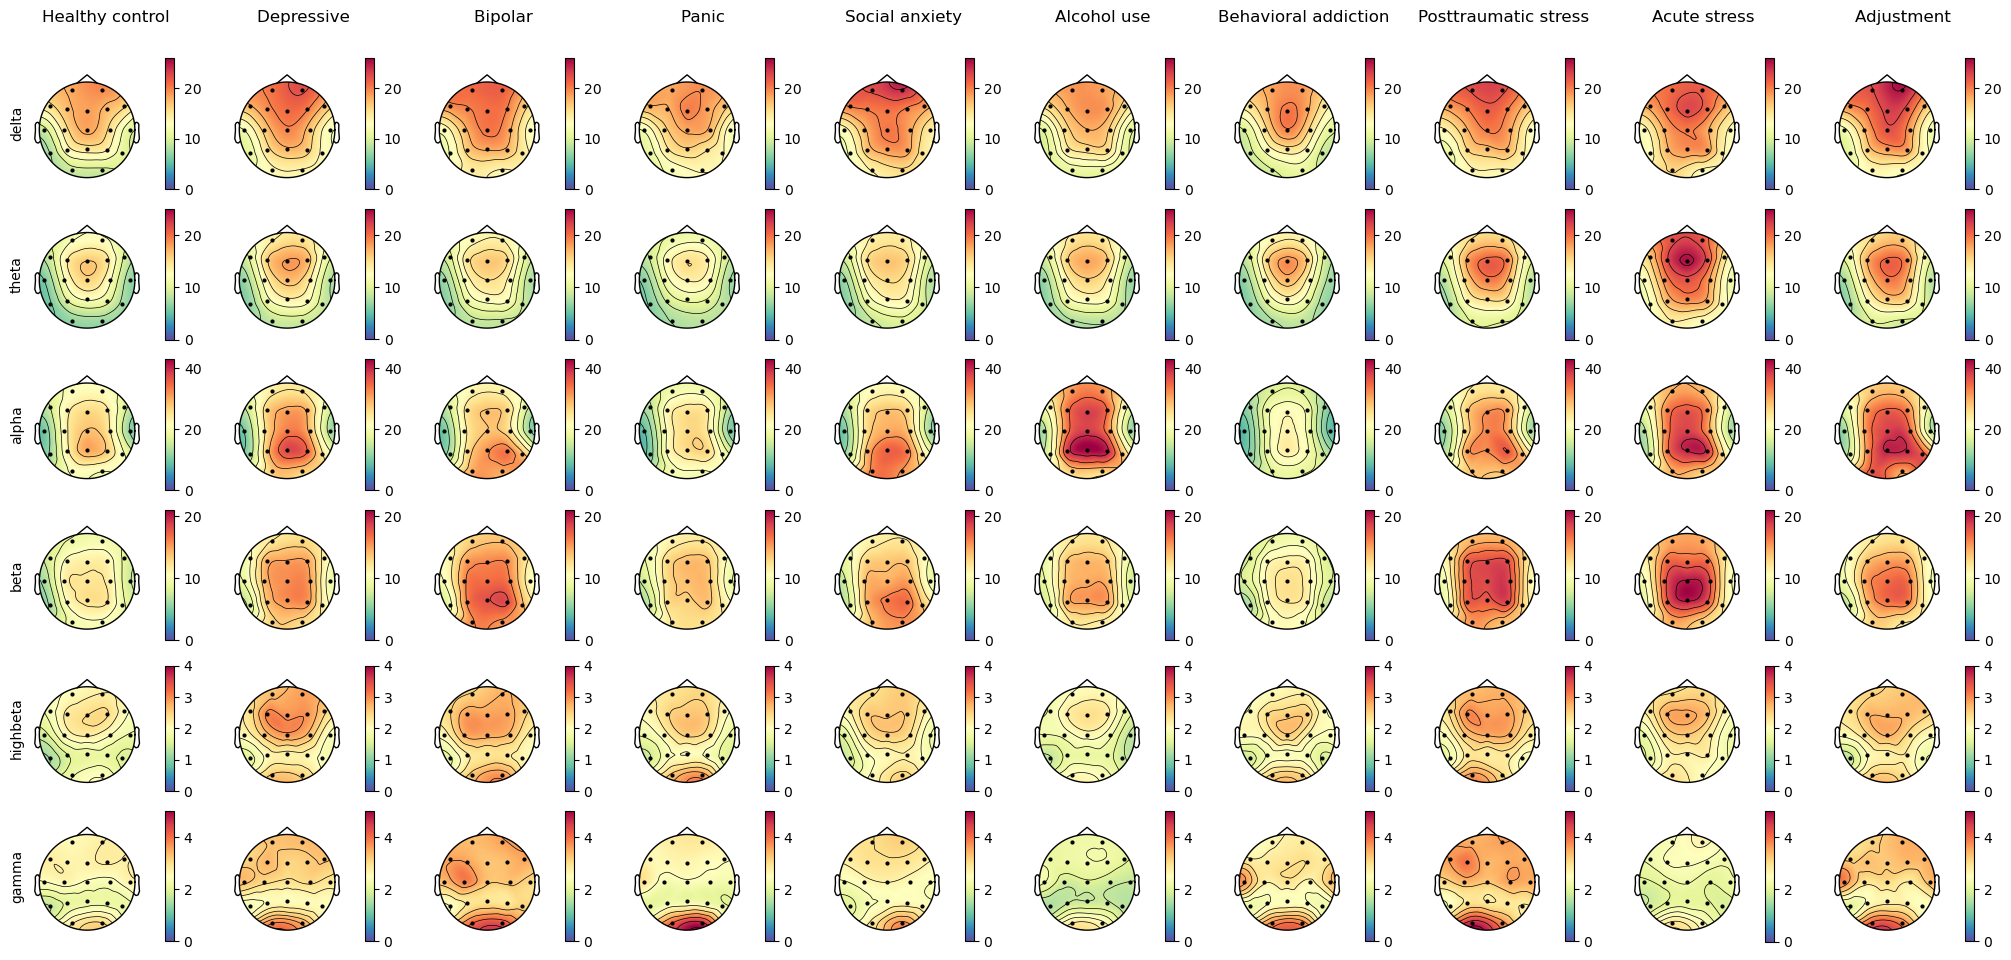

In [34]:
conds = ['Healthy control', 
         'Depressive disorder', 
         'Bipolar disorder',
         'Panic disorder',
         'Social anxiety disorder',
         'Alcohol use disorder',
         'Behavioral addiction disorder',
         'Posttraumatic stress disorder',
         'Acute stress disorder', 
         'Adjustment disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

As we can see, there are differences in avereged QEEG PSD between people with different desorders.

# Conclusions
- Disorders can be distinguished with QEEG
- The data has class disbalance
- We can try multi-class classification however binary classifications of healthy control vs. main/specific disorders are more likely to yield better results and to see how well disorders can be distiguished and see what features in EEG data are important.